#  **PREDICT** (**P**redict p**R**operties from **E**xisting **D**atabase in **C**omplex-alloys **T**erritory) FCC Ni-Cu-Au-Pd-Pt Mechanical Properties Machine Learning Framework

### This code will take the input from a relaxed, 16 atom 2 x 2 x 1 unit cell FCC structure containing Ni, Cu, Au, Pd, and or Pt elements and predict the elastic constants, Young's moduli in various directions, bulk and shear moduli, and Poisson's ratio of the material of interest. This is acheived by using the bond lengths, the bond types, and the cohesive energy of the input structure as the descriptors in the model. This framework then predicts the desired mechanical property of ternary, quaternary, and quinary structures in the Ni-Cu-Au-Pd-Pt system.

## Step 1.
#### Import the necessary Python libraries

In [1]:
import pandas as pd    # imports pandas, a data science package
import numpy as np     # imports numpy, a math and matrix package
import math            # imports math, allowing us to do sqrt
import matplotlib.pyplot as plt   # for plotting the values, %matplotlib inline needed to plot correctly in jupyter
%matplotlib inline 
import time
from pylab import text

# Scikit-Learn metrics
from sklearn.model_selection import train_test_split as tts    # splits the descriptors into testing and training sets
from sklearn.svm import SVR   #import whichever algorithim you want to do ML with
from sklearn.metrics import mean_squared_error as mse    # mean squared value, need to take sqrt to get root mean square error
from sklearn.metrics import r2_score as r2s

# Different Scikit-Learn models
from sklearn import datasets, linear_model, preprocessing
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold as kf
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import GridSearchCV as gs
from sklearn.model_selection import RandomizedSearchCV as rscv
from sklearn.neural_network import MLPRegressor as MLPR

#### Import training data

In [2]:
pd.set_option('display.max_columns', None)
# Read in the trainig data from where it is stored
Ni_Cu = pd.read_csv('binary_data/1-Ni-Cu.csv')
Ni_Au = pd.read_csv('binary_data/2-Ni-Au.csv')
Ni_Pd = pd.read_csv('binary_data/3-Ni-Pd.csv')
Ni_Pt = pd.read_csv('binary_data/4-Ni-Pt.csv')
Cu_Au = pd.read_csv('binary_data/5-Cu-Au.csv')
Cu_Pd = pd.read_csv('binary_data/6-Cu-Pd.csv')
Cu_Pt = pd.read_csv('binary_data/7-Cu-Pt.csv')
Au_Pd = pd.read_csv('binary_data/8-Au-Pd.csv')
Au_Pt = pd.read_csv('binary_data/9-Au-Pt.csv')
Pd_Pt = pd.read_csv('binary_data/10-Pd-Pt.csv')


iso_energy = {"Cu": -0.23363064,"Ni": -0.29498335,"Au": -0.18347041,"Pd":-1.46314009,"Pt":-0.55340279}
ind_coh_energy = {'Ni': -5.17, "Cu": -3.49, 'Au':-3.04,"Pd":-3.75,"Pt":-5.54}
ind_E_vrh = {'Ni': 242.7705232, 'Cu': 160.6921993,'Au': 80.1181,'Pd': 123.3284,"Pt": 162.253034}

# Combine all binary data into one dataset
binary_data = pd.concat([Ni_Cu,Ni_Au,Ni_Pd,Ni_Pt,Cu_Au,Cu_Pd,Cu_Pt,Au_Pd,Au_Pt,Pd_Pt],ignore_index=True)


## Step 2
#### Split the data into descriptors and target values

In [3]:
# Specify what you want to predict, you can choose from several different desired outputs such as 
# one of the elastic constants, or the Voigt-Ruess-Hill Young's modulus (E_VRH). Just use the same
# notation as shown in the column names above for the descripto
target = 'E_VRH'
to_drop = ['Structure','percent_cu','percent_ni','percent_au','percent_pd','percent_pt','c11','c12','c13','c23','c22','c33'\
               ,'c44','c55','c66','G_V','G_R','G','B','E_100','E_110','E_111','E_113','E_331','E_VRH','nu','avg_r']

In [4]:
desc = binary_data.drop(to_drop,axis =1)#.drop(binary_data.columns[binary_data.columns.str.contains('Type')],axis=1)
tar = binary_data[target]           # creates the target value vector

## Step 3
#### Split the data into testing and training datasets

In [5]:
train_desc, test_desc, train_tar, test_tar = tts(desc, tar, test_size=0.2, random_state=732)
train_desc.head()

,Cohesive_energy,1 r,2 r,3 r,4 r,5 r,6 r,7 r,8 r,9 r,10 r,11 r,12 r,13 r,14 r,15 r,16 r,17 r,18 r,19 r,20 r,21 r,22 r,23 r,24 r,25 r,26 r,27 r,28 r,29 r,30 r,31 r,32 r,33 r,34 r,35 r,36 r,37 r,38 r,39 r,40 r,41 r,42 r,43 r,44 r,45 r,46 r,47 r,48 r,49 r,50 r,51 r,52 r,53 r,54 r,55 r,56 r,57 r,58 r,59 r,60 r,61 r,62 r,63 r,64 r,65 r,66 r,67 r,68 r,69 r,70 r,71 r,72 r,73 r,74 r,75 r,76 r,77 r,78 r,79 r,80 r,81 r,82 r,83 r,84 r,85 r,86 r,87 r,88 r,89 r,90 r,91 r,92 r,93 r,94 r,95 r,96 r,1 Type 1,2 Type 1,3 Type 1,4 Type 1,5 Type 1,6 Type 1,7 Type 1,8 Type 1,9 Type 1,10 Type 1,11 Type 1,12 Type 1,13 Type 1,14 Type 1,15 Type 1,16 Type 1,17 Type 1,18 Type 1,19 Type 1,20 Type 1,21 Type 1,22 Type 1,23 Type 1,24 Type 1,25 Type 1,26 Type 1,27 Type 1,28 Type 1,29 Type 1,30 Type 1,31 Type 1,32 Type 1,33 Type 1,34 Type 1,35 Type 1,36 Type 1,37 Type 1,38 Type 1,39 Type 1,40 Type 1,41 Type 1,42 Type 1,43 Type 1,44 Type 1,45 Type 1,46 Type 1,47 Type 1,48 Type 1,49 Type 1,50 Type 1,51 Type 1,52 Type 1,53 Type 1,54 Type 1,55 Type 1,56 Type 1,57 Type 1,58 Type 1,59 Type 1,60 Type 1,61 Type 1,62 Type 1,63 Type 1,64 Type 1,65 Type 1,66 Type 1,67 Type 1,68 Type 1,69 Type 1,70 Type 1,71 Type 1,72 Type 1,73 Type 1,74 Type 1,75 Type 1,76 Type 1,77 Type 1,78 Type 1,79 Type 1,80 Type 1,81 Type 1,82 Type 1,83 Type 1,84 Type 1,85 Type 1,86 Type 1,87 Type 1,88 Type 1,89 Type 1,90 Type 1,91 Type 1,92 Type 1,93 Type 1,94 Type 1,95 Type 1,96 Type 1,1 Type 2,2 Type 2,3 Type 2,4 Type 2,5 Type 2,6 Type 2,7 Type 2,8 Type 2,9 Type 2,10 Type 2,11 Type 2,12 Type 2,13 Type 2,14 Type 2,15 Type 2,16 Type 2,17 Type 2,18 Type 2,19 Type 2,20 Type 2,21 Type 2,22 Type 2,23 Type 2,24 Type 2,25 Type 2,26 Type 2,27 Type 2,28 Type 2,29 Type 2,30 Type 2,31 Type 2,32 Type 2,33 Type 2,34 Type 2,35 Type 2,36 Type 2,37 Type 2,38 Type 2,39 Type 2,40 Type 2,41 Type 2,42 Type 2,43 Type 2,44 Type 2,45 Type 2,46 Type 2,47 Type 2,48 Type 2,49 Type 2,50 Type 2,51 Type 2,52 Type 2,53 Type 2,54 Type 2,55 Type 2,56 Type 2,57 Type 2,58 Type 2,59 Type 2,60 Type 2,61 Type 2,62 Type 2,63 Type 2,64 Type 2,65 Type 2,66 Type 2,67 Type 2,68 Type 2,69 Type 2,70 Type 2,71 Type 2,72 Type 2,73 Type 2,74 Type 2,75 Type 2,76 Type 2,77 Type 2,78 Type 2,79 Type 2,80 Type 2,81 Type 2,82 Type 2,83 Type 2,84 Type 2,85 Type 2,86 Type 2,87 Type 2,88 Type 2,89 Type 2,90 Type 2,91 Type 2,92 Type 2,93 Type 2,94 Type 2,95 Type 2,96 Type 2
198,-3.887608,2.855608,2.614242,3.145811,2.836267,2.962406,2.962406,2.737457,2.737457,2.640051,2.640051,2.892381,2.892381,2.666791,2.424569,2.774551,2.582051,2.758879,2.758879,2.548908,2.548908,2.639510,2.639510,2.816200,2.795144,2.797692,2.653043,2.762077,2.762077,2.979917,2.979917,2.737047,2.737047,2.782887,2.782887,2.753209,2.565368,2.682437,2.682437,2.745719,2.745719,2.544554,2.544554,2.743715,2.743715,3.063659,3.006216,2.714405,2.714405,2.920742,2.920742,2.818684,2.818684,2.937925,2.937925,2.719325,2.695462,2.817733,2.817733,2.666474,2.666474,2.596576,2.596576,2.924197,2.903924,2.807256,2.807256,2.818323,2.818323,2.930837,2.930837,2.661220,2.638928,2.830983,2.830983,2.916963,2.916963,2.844143,2.844143,2.566911,2.589823,2.925154,2.653850,2.861844,2.674378,2.616971,2.395919,2.894531,2.617195,3.027809,2.697413,2.779080,2.564141,2.961508,2.764741,2.936613,2.759207,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,

## Step 4
#### Train the model

In [6]:
# Random Forest Regression
np.random.seed(732)
model = RFR()

#### Fit your model

In [7]:
start=time.time()
model.fit(train_desc,train_tar)  #fits algorithm to training dataset
end = time.time()
total_time = round(end-start,2)
total_time

4.87

## Step 5
#### Evaluate the performance of your model

In [8]:
train_pred = model.predict(train_desc) # predicts the values for training dataset
train_rmse = math.sqrt(mse(train_tar,train_pred))  # calculate the root mean square, true values, then predicted
# train_pr = np.corrcoef(train_tar,train_pred)  # pearson coefficient, true values, then predicted
train_r2 = r2s(train_tar,train_pred)   # calculates the coefficient of determination
# print('Train RMSE: '+str(round(train_rmse,3))+str('  ')+'Train Pearson: '+str(round(train_pr.item(1),2)))  # item is due to train_pr being a matrix
print('Train RMSE: '+str(round(train_rmse,3))+str('  ')+'Train R\u00b2: '+str(round(train_r2,2)))

test_pred = model.predict(test_desc) # predicts the values for training dataset
test_rmse = math.sqrt(mse(test_tar,test_pred))  # calculate the root mean square, true values, then predicted
#test_pr = np.corrcoef(test_tar,test_pred)  # pearson coefficient, true values, then predicted
test_r2 = r2s(test_tar,test_pred)   # calculates the coefficient of determination
# print('Test RMSE: '+str(round(test_rmse,3))+str('  ')+'Test Pearson: '+str(round(test_pr.item(1),2)))  # item is due to train_pr being a matrix
print('Test RMSE: '+str(round(test_rmse,3))+str('  ')+'Test R\u00b2: '+str(round(test_r2,2)))

Train RMSE: 3.656  Train R²: 0.99
Test RMSE: 8.514  Test R²: 0.96


# Ternaries

## Step 6
#### Test the model on unseen ternary data

In [9]:
Ni_Cu_Au = pd.read_csv('ternary_data/1-Ni-Cu-Au.csv')
Ni_Cu_Pd = pd.read_csv('ternary_data/2-Ni-Cu-Pd.csv')
Ni_Au_Pd = pd.read_csv('ternary_data/3-Ni-Au-Pd.csv')
Cu_Au_Pd = pd.read_csv('ternary_data/4-Cu-Au-Pd.csv')

ternary_data = pd.concat([Ni_Cu_Au,Ni_Cu_Pd,Ni_Au_Pd,Cu_Au_Pd],ignore_index=True)
ternary_data

,Structure,percent_cu,percent_ni,percent_au,percent_pd,percent_pt,Cohesive_energy,c11,c12,c13,c23,c22,c33,c44,c55,c66,G_V,G_R,G,B,E_100,E_110,E_111,E_113,E_331,E_VRH,nu,avg_r,1 r,2 r,3 r,4 r,5 r,6 r,7 r,8 r,9 r,10 r,11 r,12 r,13 r,14 r,15 r,16 r,17 r,18 r,19 r,20 r,21 r,22 r,23 r,24 r,25 r,26 r,27 r,28 r,29 r,30 r,31 r,32 r,33 r,34 r,35 r,36 r,37 r,38 r,39 r,40 r,41 r,42 r,43 r,44 r,45 r,46 r,47 r,48 r,49 r,50 r,51 r,52 r,53 r,54 r,55 r,56 r,57 r,58 r,59 r,60 r,61 r,62 r,63 r,64 r,65 r,66 r,67 r,68 r,69 r,70 r,71 r,72 r,73 r,74 r,75 r,76 r,77 r,78 r,79 r,80 r,81 r,82 r,83 r,84 r,85 r,86 r,87 r,88 r,89 r,90 r,91 r,92 r,93 r,94 r,95 r,96 r,1 Type 1,2 Type 1,3 Type 1,4 Type 1,5 Type 1,6 Type 1,7 Type 1,8 Type 1,9 Type 1,10 Type 1,11 Type 1,12 Type 1,13 Type 1,14 Type 1,15 Type 1,16 Type 1,17 Type 1,18 Type 1,19 Type 1,20 Type 1,21 Type 1,22 Type 1,23 Type 1,24 Type 1,25 Type 1,26 Type 1,27 Type 1,28 Type 1,29 Type 1,30 Type 1,31 Type 1,32 Type 1,33 Type 1,34 Type 1,35 Type 1,36 Type 1,37 Type 1,38 Type 1,39 Type 1,40 Type 1,41 Type 1,42 Type 1,43 Type 1,44 Type 1,45 Type 1,46 Type 1,47 Type 1,48 Type 1,49 Type 1,50 Type 1,51 Type 1,52 Type 1,53 Type 1,54 Type 1,55 Type 1,56 Type 1,57 Type 1,58 Type 1,59 Type 1,60 Type 1,61 Type 1,62 Type 1,63 Type 1,64 Type 1,65 Type 1,66 Type 1,67 Type 1,68 Type 1,69 Type 1,70 Type 1,71 Type 1,72 Type 1,73 Type 1,74 Type 1,75 Type 1,76 Type 1,77 Type 1,78 Type 1,79 Type 1,80 Type 1,81 Type 1,82 Type 1,83 Type 1,84 Type 1,85 Type 1,86 Type 1,87 Type 1,88 Type 1,89 Type 1,90 Type 1,91 Type 1,92 Type 1,93 Type 1,94 Type 1,95 Type 1,96 Type 1,1 Type 2,2 Type 2,3 Type 2,4 Type 2,5 Type 2,6 Type 2,7 Type 2,8 Type 2,9 Type 2,10 Type 2,11 Type 2,12 Type 2,13 Type 2,14 Type 2,15 Type 2,16 Type 2,17 Type 2,18 Type 2,19 Type 2,20 Type 2,21 Type 2,22 Type 2,23 Type 2,24 Type 2,25 Type 2,26 Type 2,27 Type 2,28 Type 2,29 Type 2,30 Type 2,31 Type 2,32 Type 2,33 Type 2,34 Type 2,35 Type 2,36 Type 2,37 Type 2,38 Type 2,39 Type 2,40 Type 2,41 Type 2,42 Type 2,43 Type 2,44 Type 2,45 Type 2,46 Type 2,47 Type 2,48 Type 2,49 Type 2,50 Type 2,51 Type 2,52 Type 2,53 Type 2,54 Type 2,55 Type 2,56 Type 2,57 Type 2,58 Type 2,59 Type 2,60 Type 2,61 Type 2,62 Type 2,63 Type 2,64 Type 2,65 Type 2,66 Type 2,67 Type 2,68 Type 2,69 Type 2,70 Type 2,71 Type 2,72 Type 2,73 Type 2,74 Type 2,75 Type 2,76 Type 2,77 Type 2,78 Type 2,79 Type 2,80 Type 2,81 Type 2,82 Type 2,83 Type 2,84 Type 2,85 Type 2,86 Type 2,87 Type 2,88 Type 2,89 Type 2,90 Type 2,91 Type 2,92 Type 2,93 Type 2,94 Type 2,95 Type 2,96 Type 2
0,1,31.25,37.5,31.25,0.00,0.0,-3.933529,186.96476,128.78795,143.36694,139.39535,193.84915,180.02746,41.77209,71.72690,64.29340,45.511220,35.885847,40.698534,153.771317,66.495425,114.226159,150.153009,90.158223,122.770133,112.197218,0.378394,2.825713,2.615145,2.691671,2.706797,2.831884,2.654031,2.654031,2.762302,2.762302,2.662906,2.662906,2.803937,2.803937,2.515006,2.874984,2.867609,3.051127,2.522620,2.522620,2.710870,2.710870,2.476944,2.476944,2.725565,2.725565,2.603168,2.675199,2.546455,2.546455,2.582719,2.582719,2.559085,2.559085,2.555049,2.555049,2.541827,2.564013,2.617980,2.617980,2.652605,2.652605,2.867066,2.867066,2.543132,2.543132,2.692418,2.646822,2.490210,2.512129,2.581417,2.602568,2.561147,2.582463,2.623778,2.644590,2.870900,2.847057,2.599937,2.599937,2.752768,2.752768,2.734234,2.734234,2.815302,2.815302,2.807556,2.807556,2.693223,2.693223,2.643225,2.643225,2.785515,2.785515,2.825659,2.825659,2.620962,2.620962,2.534487,2.534487,2.692393,2.692393,2.656257,2.415866,3.014969,2.776872,2.825160,2.618722,2.902245,2.706316,2.456051,2.557041,2.612519,2.992911,2.697897,2.981302,2.545476,2.825713,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.

#### Split the data into descriptors and target values

In [10]:
unseen_tern_desc = ternary_data.drop(to_drop,axis =1)#.drop(ternary_data.columns[ternary_data.columns.str.contains('Type')],axis=1)
unseen_tern_tar = ternary_data[target]           # creates the target value vector

#### Test the model on the unseen data

In [11]:
unseen_tern_pred = model.predict(unseen_tern_desc) # predict model
unseen_tern_rmse = math.sqrt(mse(unseen_tern_tar,unseen_tern_pred)) # use math to get the square root, true values, then predicted
unseen_tern_pr = np.corrcoef(unseen_tern_tar,unseen_tern_pred) # numpy used for pearson coefficient, true values, then predicted
unseen_tern_r2 = r2s(unseen_tern_tar,unseen_tern_pred)
print('Unseen RMSE: ' + str(round(unseen_tern_rmse,3)) + str('     ') + 'Unseen Pearson: ' + str(round(unseen_tern_pr.item(1),2)))  #item is due to it being a matrix
print('Unseen RMSE: '+str(round(unseen_tern_rmse,3))+str('      ')+'Unseen R\u00b2: '+str(round(unseen_tern_r2,2)))
unseen_tern_pred[1:5,]

Unseen RMSE: 10.635     Unseen Pearson: 0.94
Unseen RMSE: 10.635      Unseen R²: 0.89


array([121.52163746, 117.08304241, 134.12804833, 129.64382706])

##### Optional: save your predictions to a csv file

In [12]:
np.savetxt("./ml_predictions/%s-ternary_pred.csv" %target, unseen_tern_pred, delimiter=",")

## Step 7
#### Plot the predictions for the training, testing, and unseen data

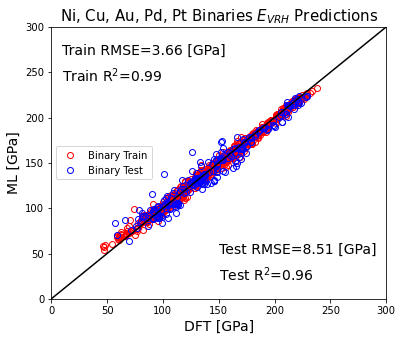

In [13]:
# Plot the training and testing predictions vs actual

plt.figure(figsize=[6,5])

if target == 'Cohesive_energy':
    x=-7
    y=x+7
    units = 'eV/atom'
    text(x+1, y-1, "Train RMSE="+str(round(train_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+1, y-2,"Train R$^2$="+str(round(train_r2,2)),fontsize=14)
    text(x+3.5, x+2, "TestRMSE="+str(round(test_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+3.5, x+1,"Test R$^2$="+str(round(test_r2,2)),fontsize=14)
    
    plt.title("Ni, Cu, Au, Pd, Pt Binaries $E_{coh}$ Predictions",fontsize=15)
    

elif target == "nu":
    x = 0.2
    y = x+.3
    units = ''
    text(x+.01, y-.030, "Train RMSE="+str(round(train_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+.010, y-.060,"Train R$^2$="+str(round(train_r2,2)),fontsize=14)
    text(x+.150, x+.050, "Test RMSE="+str(round(test_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot 
    text(x+.150, x+.020,"Test R$^2$="+str(round(test_r2,2)),fontsize=14)
    
    plt.title("Ni, Cu, Au, Pd, Pt Binaries $\\nu$ Predictions",fontsize=15)
    
    
elif target == "E_VRH":
    x = 0
    y = x+300
    units = 'GPa'
    text(x+10, y-30, "Train RMSE="+str(round(train_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+10, y-60,"Train R$^2$="+str(round(train_r2,2)),fontsize=14)
    text(x+150, x+50, "Test RMSE="+str(round(test_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot 
    text(x+150, x+20,"Test R$^2$="+str(round(test_r2,2)),fontsize=14)
    
    plt.title("Ni, Cu, Au, Pd, Pt Binaries $E_{VRH}$ Predictions",fontsize=15)

else:
    x = 0
    y = x+300
    units = 'GPa'
    text(x+10, y-30, "Train RMSE="+str(round(train_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+10, y-60,"Train R$^2$="+str(round(train_r2,2)),fontsize=14)
    text(x+150, x+50, "Test RMSE="+str(round(test_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot 
    text(x+150, x+20,"Test R$^2$="+str(round(test_r2,2)),fontsize=14)

    plt.title("Ni, Cu, Au, Pd, Pt Binaries %s Predictions" %target.title(),fontsize=18)
    
    
plt.plot(train_tar,train_pred,'ro',mfc='none',label='Binary Train')
plt.plot(test_tar, test_pred, 'bo', mfc='none',label='Binary Test') 

plt.xlim(x,y) 
plt.ylim(x,y) 

plt.xlabel("DFT [%s]" %units,fontsize=14) #x axis label
plt.ylabel("ML [%s]" %units,fontsize=14) #y axis label

c =  np.linspace(x,y,10) # strait line from corner to corner
plt.plot(c,c,'k-') #k=black, -=solid line
plt.legend(loc=6)
# plt.savefig("./figures/All_Binaries-%s.svg"%target)
plt.show() #shows the plot

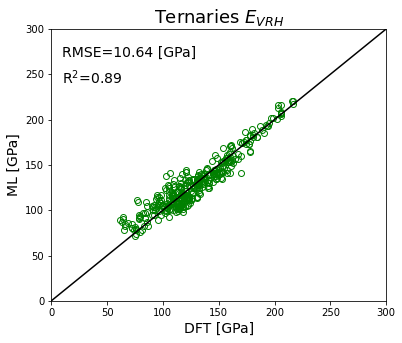

In [14]:
# Plot the training and testing predictions vs actual
plt.figure(figsize=[6,5])
# plt.figure(figsize=[3.25,3.15])

if target == 'Cohesive_energy':
    x=-7
    y=x+7
    units = 'eV/atom'
    text(x+1, y-1, "RMSE="+str(round(unseen_tern_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    # text(x+1,y-3,"Pearson="+str(round(unseen_tern_pr.item(1),2)),fontsize=14) #prints the Pearson on the plot
    text(x+1, y-2,"R$^2$="+str(round(unseen_tern_r2,2)),fontsize=14)
    text(x, x-10, "Model: %s" %(model),fontsize=14)
    
    plt.title("Ternaries $E_{coh}$" ,fontsize=18) #Plot title
    
    
elif target == "nu":
    x = 0.2
    y = x+.3
    units = ''
    text(x+.01, y-.030, "RMSE="+str(round(unseen_tern_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+.010, y-.060,"R$^2$="+str(round(unseen_tern_r2,2)),fontsize=14)
    
    plt.title("Ternaries $\\nu$",fontsize=18)
    
elif target == "E_VRH":
    x = 0
    y = x + 300
    units = 'GPa'
    
    text(x+10, y-30, "RMSE="+str(round(unseen_tern_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+10, y-60,"R$^2$="+str(round(unseen_tern_r2,2)),fontsize=14)
    
    plt.title("Ternaries $E_{VRH}$" ,fontsize=18) #Plot title
    
else:
    x = 0
    y = x+300
    units = 'GPa'
    text(x+10, y-30, "RMSE="+str(round(unseen_tern_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+5, y-15, "RMSE="+str(round(unseen_tern_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+7.5, y-22.5, "RMSE="+str(round(unseen_tern_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+10,y-90,"Pearson="+str(round(unseen_tern_pr.item(1),2)),fontsize=14) #prints the Pearson on the plot
    text(x+10, y-60,"R$^2$="+str(round(unseen_tern_r2,2)),fontsize=14)
#     text(x+5, y-30,"R$^2$="+str(round(unseen_tern_r2,2)),fontsize=14)
#     text(x+7.5, y-45,"R$^2$="+str(round(unseen_tern_r2,2)),fontsize=14)
    #text(x, x-100, "Model: %s" %(model),fontsize=14)
    
    plt.title("Ternaries $%s$" %target.title(),fontsize=18)
    


plt.plot(unseen_tern_tar, unseen_tern_pred, 'o',color='g',mfc='none',label='Ternary Test') 

plt.xlim(x,y) 
plt.ylim(x,y) 

plt.xlabel("DFT [%s]" %units,fontsize=14) #x axis label
plt.ylabel("ML [%s]" %units,fontsize=14) #y axis label
  
c =  np.linspace(x,y,10) # strait line from corner to corner
plt.plot(c,c,'k-') #k=black, -=solid line

#plt.savefig("./figures/ternaries-%s.svg"%target, bbox_inches="tight")
plt.show() #shows the plot

# Quaternaries

## Step 6
#### Test the model on unseen quaternary data

In [15]:
Ni_Cu_Au_Pd = pd.read_csv("quaternary_data/1-Ni-Cu-Au-Pd.csv")
Ni_Cu_Au_Pt = pd.read_csv("quaternary_data/2-Ni-Cu-Au-Pt.csv")

quaternaries = pd.concat([Ni_Cu_Au_Pd,Ni_Cu_Au_Pt],ignore_index=True)
quaternaries.head()

,Structure,percent_cu,percent_ni,percent_au,percent_pd,percent_pt,Cohesive_energy,c11,c12,c13,c23,c22,c33,c44,c55,c66,G_V,G_R,G,B,E_100,E_110,E_111,E_113,E_331,E_VRH,nu,avg_r,1 r,2 r,3 r,4 r,5 r,6 r,7 r,8 r,9 r,10 r,11 r,12 r,13 r,14 r,15 r,16 r,17 r,18 r,19 r,20 r,21 r,22 r,23 r,24 r,25 r,26 r,27 r,28 r,29 r,30 r,31 r,32 r,33 r,34 r,35 r,36 r,37 r,38 r,39 r,40 r,41 r,42 r,43 r,44 r,45 r,46 r,47 r,48 r,49 r,50 r,51 r,52 r,53 r,54 r,55 r,56 r,57 r,58 r,59 r,60 r,61 r,62 r,63 r,64 r,65 r,66 r,67 r,68 r,69 r,70 r,71 r,72 r,73 r,74 r,75 r,76 r,77 r,78 r,79 r,80 r,81 r,82 r,83 r,84 r,85 r,86 r,87 r,88 r,89 r,90 r,91 r,92 r,93 r,94 r,95 r,96 r,1 Type 1,2 Type 1,3 Type 1,4 Type 1,5 Type 1,6 Type 1,7 Type 1,8 Type 1,9 Type 1,10 Type 1,11 Type 1,12 Type 1,13 Type 1,14 Type 1,15 Type 1,16 Type 1,17 Type 1,18 Type 1,19 Type 1,20 Type 1,21 Type 1,22 Type 1,23 Type 1,24 Type 1,25 Type 1,26 Type 1,27 Type 1,28 Type 1,29 Type 1,30 Type 1,31 Type 1,32 Type 1,33 Type 1,34 Type 1,35 Type 1,36 Type 1,37 Type 1,38 Type 1,39 Type 1,40 Type 1,41 Type 1,42 Type 1,43 Type 1,44 Type 1,45 Type 1,46 Type 1,47 Type 1,48 Type 1,49 Type 1,50 Type 1,51 Type 1,52 Type 1,53 Type 1,54 Type 1,55 Type 1,56 Type 1,57 Type 1,58 Type 1,59 Type 1,60 Type 1,61 Type 1,62 Type 1,63 Type 1,64 Type 1,65 Type 1,66 Type 1,67 Type 1,68 Type 1,69 Type 1,70 Type 1,71 Type 1,72 Type 1,73 Type 1,74 Type 1,75 Type 1,76 Type 1,77 Type 1,78 Type 1,79 Type 1,80 Type 1,81 Type 1,82 Type 1,83 Type 1,84 Type 1,85 Type 1,86 Type 1,87 Type 1,88 Type 1,89 Type 1,90 Type 1,91 Type 1,92 Type 1,93 Type 1,94 Type 1,95 Type 1,96 Type 1,1 Type 2,2 Type 2,3 Type 2,4 Type 2,5 Type 2,6 Type 2,7 Type 2,8 Type 2,9 Type 2,10 Type 2,11 Type 2,12 Type 2,13 Type 2,14 Type 2,15 Type 2,16 Type 2,17 Type 2,18 Type 2,19 Type 2,20 Type 2,21 Type 2,22 Type 2,23 Type 2,24 Type 2,25 Type 2,26 Type 2,27 Type 2,28 Type 2,29 Type 2,30 Type 2,31 Type 2,32 Type 2,33 Type 2,34 Type 2,35 Type 2,36 Type 2,37 Type 2,38 Type 2,39 Type 2,40 Type 2,41 Type 2,42 Type 2,43 Type 2,44 Type 2,45 Type 2,46 Type 2,47 Type 2,48 Type 2,49 Type 2,50 Type 2,51 Type 2,52 Type 2,53 Type 2,54 Type 2,55 Type 2,56 Type 2,57 Type 2,58 Type 2,59 Type 2,60 Type 2,61 Type 2,62 Type 2,63 Type 2,64 Type 2,65 Type 2,66 Type 2,67 Type 2,68 Type 2,69 Type 2,70 Type 2,71 Type 2,72 Type 2,73 Type 2,74 Type 2,75 Type 2,76 Type 2,77 Type 2,78 Type 2,79 Type 2,80 Type 2,81 Type 2,82 Type 2,83 Type 2,84 Type 2,85 Type 2,86 Type 2,87 Type 2,88 Type 2,89 Type 2,90 Type 2,91 Type 2,92 Type 2,93 Type 2,94 Type 2,95 Type 2,96 Type 2
0,2,12.5,12.5,12.5,62.5,0.0,-3.841885,183.50941,145.65379,149.23306,134.30213,202.44260,199.68714,73.72394,66.60844,78.36925,54.170337,40.044660,47.107498,160.446346,68.431154,131.274984,189.188949,97.854271,144.105697,128.724534,0.366285,2.662726,2.859428,2.780620,2.762020,2.678081,2.797487,2.797487,2.789478,2.789478,2.862879,2.862879,2.768025,2.768025,2.946367,2.841438,2.761062,2.699309,2.798350,2.798350,2.762643,2.762643,2.834601,2.834601,2.649209,2.649209,2.771856,2.803765,2.833108,2.833108,2.767266,2.767266,2.799729,2.799729,2.679866,2.679866,2.730499,2.806695,2.849037,2.849037,2.786491,2.786491,2.794992,2.794992,2.831038,2.810217,2.668264,2.578756,2.696337,2.696337,2.876453,2.876453,2.736858,2.758233,2.604257,2.604257,2.651994,2.655560,2.808510,2.808510,2.786291,2.786291,2.727796,2.749242,2.636575,2.636575,2.773426,2.773426,2.639798,2.639798,2.738169,2.738169,2.773209,2.773209,2.640389,2.640389,2.609119,2.631532,2.776085,2.776085,2.860921,2.860921,2.862951,2.778426,2.776967,2.691533,2.965908,2.861806,2.754000,2.678028,2.710550,2.778412,2.728724,2.817969,2.651862,2.647785,2.630915,2.662726,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,

In [16]:
unseen_quat_desc = quaternaries.drop(to_drop,axis =1)#.drop(ternary_data.columns[ternary_data.columns.str.contains('Type')],axis=1)
unseen_quat_tar = quaternaries[target]           # creates the target value vector

In [17]:
unseen_quat_pred = model.predict(unseen_quat_desc) # predict model
unseen_quat_rmse = math.sqrt(mse(unseen_quat_tar,unseen_quat_pred)) # use math to get the square root, true values, then predicted
unseen_quat_pr = np.corrcoef(unseen_quat_tar,unseen_quat_pred) # numpy used for pearson coefficient, true values, then predicted
unseen_quat_r2 = r2s(unseen_quat_tar,unseen_quat_pred)
print('Unseen RMSE: ' + str(round(unseen_quat_rmse,3)) + str('     ') + 'Unseen Pearson: ' + str(round(unseen_quat_pr.item(1),2)))  #item is due to it being a matrix
print('Unseen RMSE: '+str(round(unseen_quat_rmse,3))+str('      ')+'Unseen R\u00b2: '+str(round(unseen_quat_r2,2)))
unseen_quat_pred[1:5]

Unseen RMSE: 10.179     Unseen Pearson: 0.94
Unseen RMSE: 10.179      Unseen R²: 0.88


array([122.19439302, 123.72587077,  88.36650492,  97.83506524])

##### Optional: save your predictions to a csv file

In [18]:
np.savetxt("./ml_predictions/%s-quaternary_pred.csv" %target, unseen_quat_pred, delimiter=",")

## Step 7
#### Plot the predictions for the unseen data

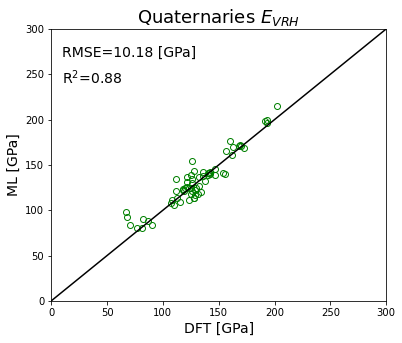

In [19]:
# Plot the training and testing predictions vs actual
plt.figure(figsize=[6,5])
# plt.figure(figsize=[3.25,3.15])

if target == 'Cohesive_energy':
    x=-7
    y=x+7
    units = 'eV/atom'
    text(x+1, y-1, "RMSE="+str(round(unseen_quat_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    # text(x+1,y-3,"Pearson="+str(round(unseen_quat_pr.item(1),2)),fontsize=14) #prints the Pearson on the plot
    text(x+1, y-2,"R$^2$="+str(round(unseen_quat_r2,2)),fontsize=14)

elif target == "nu":
    x = 0.2
    y = x+.3
    units = ''
    text(x+.01, y-.030, "RMSE="+str(round(unseen_quat_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+.010, y-.060,"R$^2$="+str(round(unseen_quat_r2,2)),fontsize=14)
#     text(y-.03,x+.01,"(b)",fontsize=14,weight='bold')
else:
    x = 0
    y = x+300
    units = 'GPa'
    
    text(x+10, y-30, "RMSE="+str(round(unseen_quat_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+10, y-60,"R$^2$="+str(round(unseen_quat_r2,2)),fontsize=14)
#     text(y-30,x+10,"(a)",fontsize=14,weight='bold')   

#     text(x+10, y-30, "RMSE="+str(round(unseen_quat_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot


#     text(x+10,y-90,"Pearson="+str(round(unseen_quat_pr.item(1),2)),fontsize=14) #prints the Pearson on the plot
#     text(x+10, y-60,"R$^2$="+str(round(unseen_quat_r2,2)),fontsize=14)

#     text(x+5, y-15, "RMSE="+str(round(unseen_quat_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+5, y-30,"R$^2$="+str(round(unseen_quat_r2,2)),fontsize=14)

#     text(x+7.5, y-22.5, "RMSE="+str(round(unseen_quat_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+7.5, y-45,"R$^2$="+str(round(unseen_quat_r2,2)),fontsize=14)

    #text(x, x-100, "Model: %s" %(model),fontsize=14)
    
    
#     text(x+3.33, y-10, "RMSE="+str(round(unseen_quat_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+3.33, y-20,"R$^2$="+str(round(unseen_quat_r2,2)),fontsize=14)
#     text(y-10,x+3.33,"(c)",fontsize=14,weight='bold')
    
#     text(x+2.66, y-8, "RMSE="+str(round(unseen_quat_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+2.66, y-16,"R$^2$="+str(round(unseen_quat_r2,2)),fontsize=14)
#     text(y-8,x+2.66,"(d)",fontsize=14,weight='bold')
    
    
    
# for 12,13,23 color=darkblue, for 11,22,33 color=g, for 44,55,66 color=m
# for E_VRH color=g, G color=royalblue, B color=m, nu color=b

plt.plot(unseen_quat_tar, unseen_quat_pred, 'o',color='g',mfc='none',label='Ternary Test') 

plt.xlim(x,y) 
plt.ylim(x,y) 

plt.xlabel("DFT [%s]" %units,fontsize=14) #x axis label
plt.ylabel("ML [%s]" %units,fontsize=14) #y axis label
if target == "E_VRH":
    plt.title("Quaternaries $E_{VRH}$" ,fontsize=18) #Plot title
elif target == "nu":
    plt.title("Quaternaries $\\nu$",fontsize=18)
else:
    plt.title("Quaternaries $C_{23}$",fontsize=18) #Plot title    
c =  np.linspace(x,y,10) # strait line from corner to corner
plt.plot(c,c,'k-') #k=black, -=solid line

# plt.savefig("./figures/quaternaries-%s.svg"%target, bbox_inches="tight")
plt.show() #shows the plot

# Quinaries

## Step 6
#### Test the model on unseen quinary data

In [20]:
quinaries = pd.read_csv("quinary_data/1-Ni-Cu-Au-Pd-Pt.csv")
quinaries.head()

,Structure,percent_cu,percent_ni,percent_au,percent_pd,percent_pt,Cohesive_energy,c11,c12,c13,c23,c22,c33,c44,c55,c66,G_V,G_R,G,B,E_100,E_110,E_111,E_113,E_331,E_VRH,nu,avg_r,1 r,2 r,3 r,4 r,5 r,6 r,7 r,8 r,9 r,10 r,11 r,12 r,13 r,14 r,15 r,16 r,17 r,18 r,19 r,20 r,21 r,22 r,23 r,24 r,25 r,26 r,27 r,28 r,29 r,30 r,31 r,32 r,33 r,34 r,35 r,36 r,37 r,38 r,39 r,40 r,41 r,42 r,43 r,44 r,45 r,46 r,47 r,48 r,49 r,50 r,51 r,52 r,53 r,54 r,55 r,56 r,57 r,58 r,59 r,60 r,61 r,62 r,63 r,64 r,65 r,66 r,67 r,68 r,69 r,70 r,71 r,72 r,73 r,74 r,75 r,76 r,77 r,78 r,79 r,80 r,81 r,82 r,83 r,84 r,85 r,86 r,87 r,88 r,89 r,90 r,91 r,92 r,93 r,94 r,95 r,96 r,1 Type 1,2 Type 1,3 Type 1,4 Type 1,5 Type 1,6 Type 1,7 Type 1,8 Type 1,9 Type 1,10 Type 1,11 Type 1,12 Type 1,13 Type 1,14 Type 1,15 Type 1,16 Type 1,17 Type 1,18 Type 1,19 Type 1,20 Type 1,21 Type 1,22 Type 1,23 Type 1,24 Type 1,25 Type 1,26 Type 1,27 Type 1,28 Type 1,29 Type 1,30 Type 1,31 Type 1,32 Type 1,33 Type 1,34 Type 1,35 Type 1,36 Type 1,37 Type 1,38 Type 1,39 Type 1,40 Type 1,41 Type 1,42 Type 1,43 Type 1,44 Type 1,45 Type 1,46 Type 1,47 Type 1,48 Type 1,49 Type 1,50 Type 1,51 Type 1,52 Type 1,53 Type 1,54 Type 1,55 Type 1,56 Type 1,57 Type 1,58 Type 1,59 Type 1,60 Type 1,61 Type 1,62 Type 1,63 Type 1,64 Type 1,65 Type 1,66 Type 1,67 Type 1,68 Type 1,69 Type 1,70 Type 1,71 Type 1,72 Type 1,73 Type 1,74 Type 1,75 Type 1,76 Type 1,77 Type 1,78 Type 1,79 Type 1,80 Type 1,81 Type 1,82 Type 1,83 Type 1,84 Type 1,85 Type 1,86 Type 1,87 Type 1,88 Type 1,89 Type 1,90 Type 1,91 Type 1,92 Type 1,93 Type 1,94 Type 1,95 Type 1,96 Type 1,1 Type 2,2 Type 2,3 Type 2,4 Type 2,5 Type 2,6 Type 2,7 Type 2,8 Type 2,9 Type 2,10 Type 2,11 Type 2,12 Type 2,13 Type 2,14 Type 2,15 Type 2,16 Type 2,17 Type 2,18 Type 2,19 Type 2,20 Type 2,21 Type 2,22 Type 2,23 Type 2,24 Type 2,25 Type 2,26 Type 2,27 Type 2,28 Type 2,29 Type 2,30 Type 2,31 Type 2,32 Type 2,33 Type 2,34 Type 2,35 Type 2,36 Type 2,37 Type 2,38 Type 2,39 Type 2,40 Type 2,41 Type 2,42 Type 2,43 Type 2,44 Type 2,45 Type 2,46 Type 2,47 Type 2,48 Type 2,49 Type 2,50 Type 2,51 Type 2,52 Type 2,53 Type 2,54 Type 2,55 Type 2,56 Type 2,57 Type 2,58 Type 2,59 Type 2,60 Type 2,61 Type 2,62 Type 2,63 Type 2,64 Type 2,65 Type 2,66 Type 2,67 Type 2,68 Type 2,69 Type 2,70 Type 2,71 Type 2,72 Type 2,73 Type 2,74 Type 2,75 Type 2,76 Type 2,77 Type 2,78 Type 2,79 Type 2,80 Type 2,81 Type 2,82 Type 2,83 Type 2,84 Type 2,85 Type 2,86 Type 2,87 Type 2,88 Type 2,89 Type 2,90 Type 2,91 Type 2,92 Type 2,93 Type 2,94 Type 2,95 Type 2,96 Type 2
0,1,18.75,18.75,18.75,18.75,25.00,-4.291514,218.09670,156.71367,156.16937,155.47043,210.19041,224.07330,72.88454,68.07334,74.20170,55.299045,46.528270,50.913658,176.563039,86.512889,145.926453,189.249408,116.238408,156.335815,139.346959,0.368463,2.614723,2.862973,2.776439,2.726079,2.644951,2.905490,2.905490,2.815485,2.815485,2.766261,2.766261,2.690252,2.711978,2.658907,2.557117,2.639587,2.505923,2.653978,2.653978,2.614193,2.614193,2.782302,2.782302,2.647152,2.647152,2.980951,2.774538,2.777867,2.777867,2.894209,2.894209,2.634508,2.634508,2.861993,2.861993,2.939592,2.756112,2.708799,2.708799,2.859696,2.859696,2.604663,2.604663,2.859992,2.859992,2.773937,2.762894,2.794020,2.794020,2.823969,2.823969,2.754197,2.754197,2.722066,2.743539,2.672398,2.638195,2.877242,2.877242,2.730299,2.730299,2.672812,2.672812,2.692238,2.692238,2.646868,2.646868,2.716755,2.716755,2.852131,2.831481,2.793179,2.793179,2.641359,2.641359,2.790831,2.790831,2.702383,2.724012,2.635211,2.635211,2.946987,2.658212,2.840498,2.558515,2.840865,2.615671,2.689067,2.485273,2.853088,2.788269,2.800231,2.733872,2.810436,2.725621,2.693458,2.614723,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,4

In [21]:
unseen_quin_desc = quinaries.drop(to_drop,axis =1)#.drop(ternary_data.columns[ternary_data.columns.str.contains('Type')],axis=1)
unseen_quin_tar = quinaries[target]           # creates the target value vector

In [22]:
start=time.time()
unseen_quin_pred = model.predict(unseen_quin_desc) # predict model
end = time.time()
total_time = round(end-start,2)
unseen_quin_rmse = math.sqrt(mse(unseen_quin_tar,unseen_quin_pred)) # use math to get the square root, true values, then predicted
unseen_quin_pr = np.corrcoef(unseen_quin_tar,unseen_quin_pred) # numpy used for pearson coefficient, true values, then predicted
unseen_quin_r2 = r2s(unseen_quin_tar,unseen_quin_pred)
print('Unseen RMSE: ' + str(round(unseen_quin_rmse,3)) + str('     ') + 'Unseen Pearson: ' + str(round(unseen_quin_pr.item(1),2)))  #item is due to it being a matrix
print('Unseen RMSE: '+str(round(unseen_quin_rmse,3))+str('      ')+'Unseen R\u00b2: '+str(round(unseen_quin_r2,2)))
print(total_time," seconds")
unseen_quin_pred[1:5,]

Unseen RMSE: 8.848     Unseen Pearson: 0.95
Unseen RMSE: 8.848      Unseen R²: 0.91
0.01  seconds


array([148.27578881, 146.78150625, 130.18520886, 133.63547493])

##### Optional: save your predictions to a csv file

In [23]:
np.savetxt("./ml_predictions/%s-quinary_pred.csv" %target, unseen_quin_pred, delimiter=",")

## Step 7
#### Plot the predictions for the unseen data

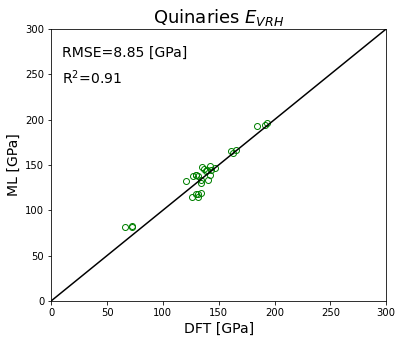

In [24]:
# Plot the training and testing predictions vs actual
plt.figure(figsize=[6,5])
# plt.figure(figsize=[3.25,3.15])

if target == 'Cohesive_energy':
    x=-7
    y=x+7
    units = 'eV/atom'
    text(x+1, y-1, "RMSE="+str(round(unseen_quin_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    # text(x+1,y-3,"Pearson="+str(round(unseen_quin_pr.item(1),2)),fontsize=14) #prints the Pearson on the plot
    text(x+1, y-2,"R$^2$="+str(round(unseen_quin_r2,2)),fontsize=14)

elif target == "nu":
    x = 0.2
    y = x+.3
    units = ''
    text(x+.01, y-.030, "RMSE="+str(round(unseen_quin_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+.010, y-.060,"R$^2$="+str(round(unseen_quin_r2,2)),fontsize=14)
#     text(y-.03,x+.01,"(b)",fontsize=14,weight='bold')
else:
    x = 0
    y = x+300
    units = 'GPa'
    
    text(x+10, y-30, "RMSE="+str(round(unseen_quin_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
    text(x+10, y-60,"R$^2$="+str(round(unseen_quin_r2,2)),fontsize=14)
#     text(y-30,x+10,"(a)",fontsize=14,weight='bold')    
    


#     text(x+10,y-90,"Pearson="+str(round(unseen_quin_pr.item(1),2)),fontsize=14) #prints the Pearson on the plot

#     text(x+5, y-15, "RMSE="+str(round(unseen_quin_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot   
#     text(x+5, y-30,"R$^2$="+str(round(unseen_quin_r2,2)),fontsize=14)

#     text(x+7.5, y-22.5, "RMSE="+str(round(unseen_quin_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+7.5, y-45,"R$^2$="+str(round(unseen_quin_r2,2)),fontsize=14)
    #text(x, x-100, "Model: %s" %(model),fontsize=14)
    

#     text(x+3.33, y-10, "RMSE="+str(round(unseen_quin_rmse,2))+' [%s]'%units, fontsize=14) #prints the RMSE on the plot
#     text(x+3.33, y-20,"R$^2$="+str(round(unseen_quin_r2,2)),fontsize=14)
#     text(y-10,x+3.33,"(d)",fontsize=14,weight='bold')
    
# for 12,13,23 color=darkblue, for 11,22,33 color=g, for 44,55,66 color=m
# for E_VRH color=g, G color=royalblue, B color=m, nu color=b

plt.plot(unseen_quin_tar, unseen_quin_pred, 'o',color='g',mfc='none',label='Ternary Test') 

plt.xlim(x,y) 
plt.ylim(x,y) 

plt.xlabel("DFT [%s]" %units,fontsize=14) #x axis label
plt.ylabel("ML [%s]" %units,fontsize=14) #y axis label
if target == "E_VRH":
    plt.title("Quinaries $E_{VRH}$" ,fontsize=18) #Plot title
elif target == "nu":
    plt.title("Quinaries $\\nu$",fontsize=18)
else:
    plt.title("Quinaries $C_{23}$",fontsize=18) #Plot title    
c =  np.linspace(x,y,10) # strait line from corner to corner
plt.plot(c,c,'k-') #k=black, -=solid line

# plt.savefig("./figures/quinaries-%s_8-6.svg"%target, bbox_inches="tight")
plt.show() #shows the plot